In [ ]:
## Python
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')


## Package
import glob
import keras
import IPython.display as ipd
!pip install librosa==0.9.2
import librosa

import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
# from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
# from keras.utils import np_utils
from keras.utils import to_categorical

from keras.models import Model, Sequential
from keras import optimizers
from keras.layers import Input, Conv1D, Conv2D,BatchNormalization, MaxPooling1D,MaxPooling2D, LSTM, Dense, Activation, Layer,Reshape

from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm_notebook as tqdm

input_duration=3
# % pylab inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.3 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.1
    Uninstalling librosa-0.10.1:
      Successfully uninstalled librosa-0.10.1


### RAVDESS DATASET


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
current_directory = os.getcwd()
print("Current Directory:", current_directory)

contents = os.listdir(current_directory)
for item in contents:
    print(item)



Current Directory: /content
.config
drive
sample_data


In [ ]:
Ravdess_paths= ["/content/drive/MyDrive/Colab Notebooks/speech","/content/drive/MyDrive/Colab Notebooks/song"]
dir_list = os.listdir(Ravdess_paths[1])
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [ ]:
# Create DataFrame for Data intel
ravdess_db = pd.DataFrame(columns=['path','source','actor', 'gender', 'emotion','emotion_lb'])
count = 0
for data_path in Ravdess_paths:
    dir_list = os.listdir(data_path)
    dir_list.sort()
    for i in dir_list:
        file_list = os.listdir(data_path + '/'+i)
        for f in file_list:
            nm = f.split('.')[0].split('-')
            path = data_path + '/' + i + '/' + f
            src = int(nm[1])
            actor = int(nm[-1])
            emotion = int(nm[2])
            source = "Ravdess"

            if int(actor)%2 == 0:
                gender = "female"
            else:
                gender = "male"

            if nm[3] == '01':
                intensity = 0
            else:
                intensity = 1

            if nm[4] == '01':
                statement = 0
            else:
                statement = 1

            if nm[5] == '01':
                repeat = 0
            else:
                repeat = 1

            if emotion == 1:
                lb = "neutral"
            elif emotion == 2:
                lb = "calm"
            elif emotion == 3:
                lb = "happy"
            elif emotion == 4:
                lb = "sad"
            elif emotion == 5:
                lb = "angry"
            elif emotion == 6:
                lb = "fearful"
            elif emotion == 7:
                lb = "disgust"
            elif emotion == 8:
                lb = "surprised"
            else:
                lb = "none"

            ravdess_db.loc[count] = [path,source,actor, gender, emotion,lb]
            count += 1

In [ ]:
ravdess_db.head()

,path,source,actor,gender,emotion,emotion_lb
0,/content/drive/MyDrive/Colab Notebooks/speech/...,Ravdess,1,male,7,disgust
1,/content/drive/MyDrive/Colab Notebooks/speech/...,Ravdess,1,male,7,disgust
2,/content/drive/MyDrive/Colab Notebooks/speech/...,Ravdess,1,male,8,surprised
3,/content/drive/MyDrive/Colab Notebooks/speech/...,Ravdess,1,male,8,surprised
4,/content/drive/MyDrive/Colab Notebooks/speech/...,Ravdess,1,male,8,surprised


In [ ]:
ravdess_db.tail()

,path,source,actor,gender,emotion,emotion_lb
2447,/content/drive/MyDrive/Colab Notebooks/song/Ac...,Ravdess,24,female,1,neutral
2448,/content/drive/MyDrive/Colab Notebooks/song/Ac...,Ravdess,24,female,4,sad
2449,/content/drive/MyDrive/Colab Notebooks/song/Ac...,Ravdess,24,female,4,sad
2450,/content/drive/MyDrive/Colab Notebooks/song/Ac...,Ravdess,24,female,6,fearful
2451,/content/drive/MyDrive/Colab Notebooks/song/Ac...,Ravdess,24,female,1,neutral


In [ ]:
ravdess_db.to_csv("/content/drive/My Drive/Colab Notebooks/list.csv")

In [ ]:
ravdess_db['split'] =  np.where((ravdess_db.actor ==23) | (ravdess_db.actor ==24), 'Test',
                                (np.where((ravdess_db.actor ==21) | (ravdess_db.actor ==22),'Val','Train')))

In [ ]:
ravdess_db['split'].value_counts()

Train    2036
Val       208
Test      208
Name: split, dtype: int64

In [ ]:
ravdess_db.drop(ravdess_db.index[ravdess_db['emotion_lb'] == 'surprised'], inplace = True)
ravdess_db.loc[ravdess_db.emotion_lb=='calm',['emotion','emotion_lb']]= 1,'neutral'

In [ ]:
ravdess_db.emotion_lb.value_counts()

neutral    564
fearful    376
sad        376
angry      376
happy      376
disgust    192
Name: emotion_lb, dtype: int64

In [ ]:
dataset_db = ravdess_db.copy()

In [ ]:
dataset_db.emotion_lb = dataset_db.gender+"_"+dataset_db.emotion_lb

In [ ]:
dataset_db.index=range(len(dataset_db.index))

In [ ]:
dataset_db.to_csv("/content/drive/My Drive/Colab Notebooks/list2.csv")

In [ ]:
dataset_db.emotion_lb.value_counts()
dataset_db.sort_values(by=['path'], inplace=True)
dataset_db.head()

,path,source,actor,gender,emotion,emotion_lb,split
1278,/content/drive/MyDrive/Colab Notebooks/song/Ac...,Ravdess,1,male,1,male_neutral,Train
1268,/content/drive/MyDrive/Colab Notebooks/song/Ac...,Ravdess,1,male,1,male_neutral,Train
1270,/content/drive/MyDrive/Colab Notebooks/song/Ac...,Ravdess,1,male,1,male_neutral,Train
1285,/content/drive/MyDrive/Colab Notebooks/song/Ac...,Ravdess,1,male,1,male_neutral,Train
1275,/content/drive/MyDrive/Colab Notebooks/song/Ac...,Ravdess,1,male,1,male_neutral,Train


In [ ]:
dataset_db.index = range(len(dataset_db.index))

In [ ]:
dataset_db.shape

(2260, 7)

In [ ]:
dataset_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260 entries, 0 to 2259
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        2260 non-null   object
 1   source      2260 non-null   object
 2   actor       2260 non-null   int64 
 3   gender      2260 non-null   object
 4   emotion     2260 non-null   int64 
 5   emotion_lb  2260 non-null   object
 6   split       2260 non-null   object
dtypes: int64(2), object(5)
memory usage: 123.7+ KB


In [ ]:
audio_duration = 3
sampling_rate = 22050*2
input_length = sampling_rate * audio_duration
n_mfcc = 20

In [ ]:
data_sample= np.zeros(input_length)
MFCC = librosa.feature.mfcc(y=data_sample, sr=sampling_rate, n_mfcc=n_mfcc)

In [ ]:
MFCC.shape



(20, 259)

###n_mfcc: This represents the number of MFCC coefficients computed for each audio frame. It corresponds to the value of the n_mfcc parameter you used when calculating the MFCCs.
###t: This represents the number of time frames or analysis windows used to compute MFCCs for the entire audio signal.

In [ ]:
MFCC

array([[-1131.3708499, -1131.3708499, -1131.3708499, ..., -1131.3708499,
        -1131.3708499, -1131.3708499],
       [    0.       ,     0.       ,     0.       , ...,     0.       ,
            0.       ,     0.       ],
       [    0.       ,     0.       ,     0.       , ...,     0.       ,
            0.       ,     0.       ],
       ...,
       [    0.       ,     0.       ,     0.       , ...,     0.       ,
            0.       ,     0.       ],
       [    0.       ,     0.       ,     0.       , ...,     0.       ,
            0.       ,     0.       ],
       [    0.       ,     0.       ,     0.       , ...,     0.       ,
            0.       ,     0.       ]])

In [ ]:
dataset_db.split.value_counts()

Train    1876
Val       192
Test      192
Name: split, dtype: int64

In [ ]:
dataset_db.path[0]

'/content/drive/MyDrive/Colab Notebooks/speech/Actor_01/03-01-07-02-01-01-01.wav'

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
librosa.__version__

'0.9.2'

In [ ]:
signal, sample_rate = librosa.load(dataset_db.path[0], res_type='kaiser_fast',sr=sampling_rate)
signal,index = librosa.effects.trim(signal,top_db = 25)
signal = scipy.signal.wiener(signal)

if len(signal) > input_length:
    signal = signal[0:input_length]
elif  input_length > len(signal):
    max_offset = input_length - len(signal)
    signal = np.pad(signal, (0, max_offset), "constant")

In [ ]:
signal = np.array(signal).reshape(-1,1)


In [ ]:
signal.shape

(132300, 1)

In [ ]:
audios= np.empty(shape=(dataset_db.shape[0],128, MFCC.shape[1], 1))

count=0
for i in tqdm(range(len(dataset_db))):
    signal, sample_rate = librosa.load(dataset_db.path[i], res_type='kaiser_fast',sr=sampling_rate)
    signal,index = librosa.effects.trim(signal,top_db = 25)
    signal = scipy.signal.wiener(signal)

    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)
        signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)
    logspec = librosa.amplitude_to_db(melspec)
    logspec = np.expand_dims(logspec, axis=-1)
    audios[count,] = logspec
    count+=1

  0%|          | 0/2260 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
audios.shape

(2260, 128, 259, 1)

In [ ]:
import h5py
with h5py.File('/content/drive/My Drive/Colab Notebooks/Ravdess_audio_Mel_spec.h5', 'w') as hf:
    hf.create_dataset("Ravdess_audio_Mel_spec",  data=audios)

In [ ]:
import h5py
with h5py.File('/content/drive/My Drive/Colab Notebooks/Ravdess_audio_Mel_spec.h5', 'r') as hf:
  audios = hf['Ravdess_audio_Mel_spec'][:]

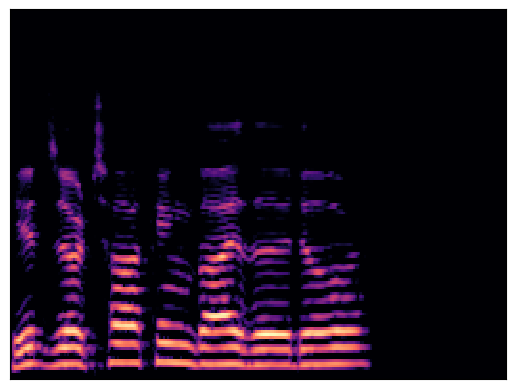

In [ ]:
librosa.display.specshow(audios[0].reshape(128,259))

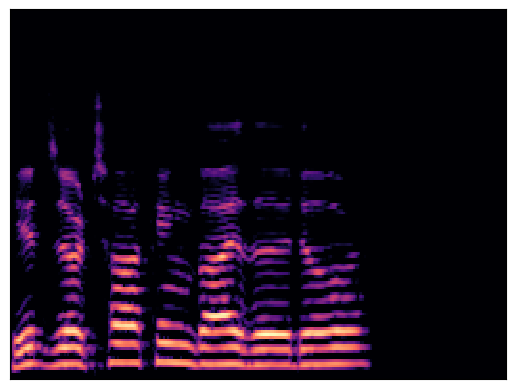

In [ ]:
librosa.display.specshow(audios[0].reshape(128,259))

In [ ]:
dataset_db.shape

(2260, 7)

In [ ]:
audios.shape

(2260, 128, 259, 1)

In [ ]:
x_train = audios[(dataset_db['split'] == 'Train')]


In [ ]:
y_train = dataset_db.emotion_lb[(dataset_db['split'] == 'Train')]



In [ ]:
print(x_train.shape,y_train.shape)

In [ ]:
y_train

0         male_neutral
1         male_neutral
2         male_neutral
3         male_neutral
4         male_neutral
             ...      
2047    female_disgust
2048    female_disgust
2049    female_disgust
2050    female_disgust
2051    female_disgust
Name: emotion_lb, Length: 1876, dtype: object

In [ ]:
x_test = audios[(dataset_db['split'] == 'Val')]



(192, 128, 259, 1) (192,)


In [ ]:
y_test = dataset_db.emotion_lb[(dataset_db['split'] == 'Val')]


In [ ]:
print(x_test.shape,y_test.shape)

In [ ]:
from tensorflow.keras import utils


In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)



ValueError: ignored

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)


In [ ]:
y_test

array(['male_neutral', 'male_neutral', 'male_neutral', 'male_neutral',
       'male_neutral', 'male_neutral', 'male_neutral', 'male_neutral',
       'male_neutral', 'male_neutral', 'male_neutral', 'male_neutral',
       'male_happy', 'male_happy', 'male_happy', 'male_happy',
       'male_happy', 'male_happy', 'male_happy', 'male_happy', 'male_sad',
       'male_sad', 'male_sad', 'male_sad', 'male_sad', 'male_sad',
       'male_sad', 'male_sad', 'male_angry', 'male_angry', 'male_angry',
       'male_angry', 'male_angry', 'male_angry', 'male_angry',
       'male_angry', 'male_fearful', 'male_fearful', 'male_fearful',
       'male_fearful', 'male_fearful', 'male_fearful', 'male_fearful',
       'male_fearful', 'female_neutral', 'female_neutral',
       'female_neutral', 'female_neutral', 'female_neutral',
       'female_neutral', 'female_neutral', 'female_neutral',
       'female_neutral', 'female_neutral', 'female_neutral',
       'female_neutral', 'female_happy', 'female_happy', 'female

In [ ]:
y_train

array(['male_neutral', 'male_neutral', 'male_neutral', ...,
       'female_disgust', 'female_disgust', 'female_disgust'], dtype=object)

In [ ]:
unique_values = set(y_train)
lb = LabelEncoder()
lb.fit(list(unique_values))

LabelEncoder()

In [ ]:
label_mapping_df = pd.DataFrame({'EncodedLabel': lb.transform(list(unique_values)), 'OriginalLabel': list(unique_values)})
label_mapping_df.to_csv('/content/drive/My Drive/Colab Notebooks/label_mapping.csv', index=False)

In [ ]:
transform = lb.transform(y_train)


In [ ]:
y_train = utils.to_categorical(transform)


In [ ]:
transform_y_test = lb.transform(y_test)

In [ ]:
y_test = utils.to_categorical(transform_y_test)


In [ ]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
x_traincnn = x_train
x_testcnn = x_test

In [ ]:
x_traincnn.shape,x_testcnn.shape,y_train.shape,y_test.shape

((1876, 128, 259, 1), (192, 128, 259, 1), (1876, 12), (192, 12))

In [ ]:
# CNN I/P Config
num_classes = len(np.unique(np.argmax(y_train, 1)))
input_shape = x_traincnn.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
input_shape

(128, 259, 1)

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128,kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())
# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 259, 128)     1280      
                                                                 
 batch_normalization (Batch  (None, 128, 259, 128)     512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128, 259, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 129, 128)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 129, 128)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 129, 128)     

In [ ]:
#Train Config

batch_size = 16
num_epochs = 100

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
#early stopping
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/Models/Audio_2DCNN_4L_R2.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])


Epoch 1/100
118/118 [==============================] - 18s 37ms/step - loss: 2.7405 - categorical_accuracy: 0.1695 - val_loss: 2.4795 - val_categorical_accuracy: 0.2969 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 4s 34ms/step - loss: 2.2444 - categorical_accuracy: 0.2415 - val_loss: 1.6825 - val_categorical_accuracy: 0.3646 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 4s 33ms/step - loss: 2.0053 - categorical_accuracy: 0.2916 - val_loss: 2.3556 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 4s 33ms/step - loss: 1.8802 - categorical_accuracy: 0.3134 - val_loss: 1.9607 - val_categorical_accuracy: 0.2240 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 4s 33ms/step - loss: 1.7635 - categorical_accuracy: 0.3428 - val_loss: 1.8448 - val_categorical_accuracy: 0.2708 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 4s 33ms/step - loss: 1.7017 - categoric

In [ ]:
max(cnnhistory.history['val_categorical_accuracy'])

0.703125

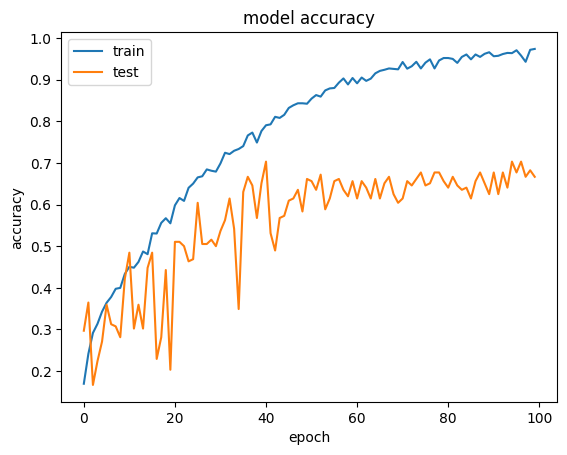

In [ ]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['categorical_accuracy'])
plt.plot(cnnhistory.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

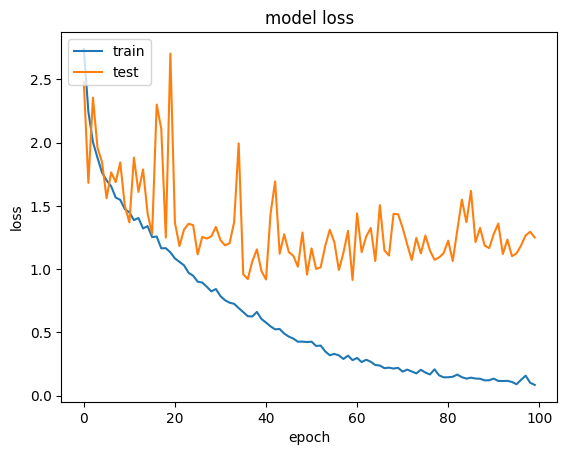

In [ ]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import json
model_json = model.to_json()
with open("/content/drive/My Drive/Colab Notebooks/Models/Audio_2DCNN_4L_R2.json", "w") as json_file:
    json_file.write(model_json)

NameError: ignored

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('/content/drive/My Drive/Colab Notebooks/Models/Audio_2DCNN_4L_R2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [ ]:
loaded_model

In [ ]:
from keras.models import load_model

# Returns a compiled model identical to the previous one
loaded_model.load_weights('/content/drive/My Drive/Colab Notebooks/Models/Audio_2DCNN_4L_R2.h5')

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

NameError: ignored

In [ ]:
x_test_data = audios[(dataset_db['split'] == 'Test')]
y_test_data = dataset_db.emotion_lb[(dataset_db['split'] == 'Test')]

print(x_test_data.shape,y_test_data.shape)

(192, 128, 259, 1) (192,)


In [ ]:
preds = loaded_model.predict(x_test_data,batch_size=16,verbose=1)
preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))

12/12 [==============================] - 7s 6ms/step


In [ ]:
abc

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9,  9,  9,  9,  9,
        9,  9,  9, 11, 11, 11, 11, 11, 11, 11, 11,  6,  8,  6,  8,  6,  6,
        6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  3,  4,  3,  3,  3,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  0,  2,  5,  2,  0,  0,  0,  2,  2,  5,  2,  2,  2,
        2,  2,  2,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 10,  9,  9,
        8,  8,  8,  8,  8,  8, 10, 10, 11, 10,  7,  1,  7,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  9, 10, 10,  8,  8,  8,  8,  7,  7,  7,  8,
        7,  7,  7,  7,  4,  5,  4,  4,  4,  5,  4,  4,  5,  4,  4,  4,  5,
        4,  5,  4,  0,  0,  2,  2,  4,  5,  4,  4,  1,  1,  1,  1,  0,  3,
        3,  0,  0,  0,  0,  0,  1,  2,  0,  0,  2,  5,  2,  2,  1,  1,  1,
        0,  7,  1,  0,  0])

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[10:30]

,predictedvalues
10,male_neutral
11,male_neutral
12,male_happy
13,male_happy
14,male_happy
15,male_happy
16,male_happy
17,male_happy
18,male_happy
19,male_happy


In [ ]:
filtered_df = preddf[preddf['predictedvalues'].str.startswith('female')]
filtered_df

,predictedvalues
44,female_neutral
45,female_neutral
46,female_neutral
47,female_neutral
48,female_neutral
...,...
186,female_disgust
187,female_angry
189,female_disgust
190,female_angry


In [ ]:
actualdf = pd.DataFrame({'actualvalues': y_test_data})
actualdf[:10]


,actualvalues
924,male_neutral
925,male_neutral
926,male_neutral
927,male_neutral
928,male_neutral
929,male_neutral
930,male_neutral
931,male_neutral
932,male_neutral
933,male_neutral


In [ ]:
actualdf.index = range(len(actualdf.index))

In [ ]:
finaldf = pd.concat([actualdf,preddf],axis=1)
finaldf.head()

,actualvalues,predictedvalues
0,male_neutral,male_neutral
1,male_neutral,male_neutral
2,male_neutral,male_neutral
3,male_neutral,male_neutral
4,male_neutral,male_neutral


In [ ]:
finaldf.tail()

,actualvalues,predictedvalues
187,female_disgust,female_angry
188,female_disgust,male_disgust
189,female_disgust,female_disgust
190,female_disgust,female_angry
191,female_disgust,female_angry


In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (9,6), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

63.541666666666664

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

61.53802240903305

In [ ]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[10,  0,  3,  2,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 3,  4,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 2,  1, 11,  0,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 2,  0,  2,  4,  6,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 21,  3,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  0,  0,  3,  9,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  6,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  7,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 13,  1,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  6, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 18,  1],
       [ 0,  1,  0,  0,  0,  0,  0,  2,  1,  0,  3,  9]])

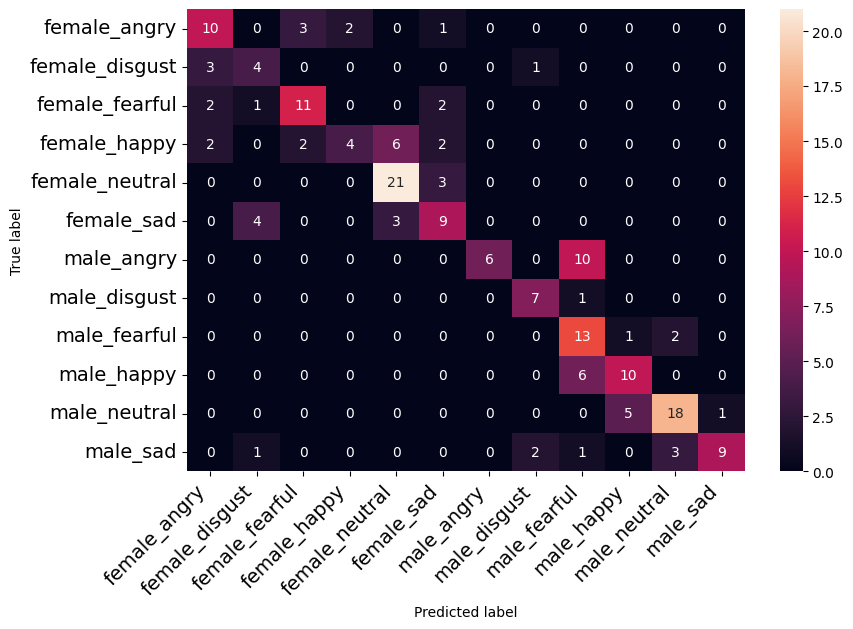

In [ ]:
class_names=sorted(set(finaldf.actualvalues))
print_confusion_matrix(c, class_names)